In [1]:
### START of Spark initial setup ###

# NOTE: Set up and initialize Spark session here. The rest of the code assumes that pyspark is accessible.

### END of Spark initial setup ###

In [2]:
import vid_spark
from vid_spark import * 
import importlib
importlib.reload(vid_spark)

import pdb

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Import the impressions tables
report_file = "weighted_impression_table_5demos_report_1"
impressions = spark.table(report_file)

impressions_exploded = explode_weights_to_impressions(impressions)

# Generate the reach tables
reach = generate_reach_table(impressions_exploded, mode="count")

print(f"The total number of exploded impressions are {impressions_exploded.count()}")
impressions_exploded.show()

The total number of exploded impressions are 431554879


,user_id,device,timestamp,weight,income_code,age_range,gender,ethnicity,education
0,10012698441,TV/Linear,2020-05-25 04:16:49,36,F,18_24,male,hispanic,Graduate Degree
1,10012698442,TV/Linear,2020-05-25 04:16:49,36,F,18_24,male,hispanic,Graduate Degree
2,10012698443,TV/Linear,2020-05-25 04:16:49,36,F,18_24,male,hispanic,Graduate Degree
3,10012698444,TV/Linear,2020-05-25 04:16:49,36,F,18_24,male,hispanic,Graduate Degree
4,10012698445,TV/Linear,2020-05-25 04:16:49,36,F,18_24,male,hispanic,Graduate Degree
5,10012698446,TV/Linear,2020-05-25 04:16:49,36,F,18_24,male,hispanic,Graduate Degree
6,10012698447,TV/Linear,2020-05-25 04:16:49,36,F,18_24,male,hispanic,Graduate Degree
7,10012698448,TV/Linear,2020-05-25 04:16:49,36,F,18_24,male,hispanic,Graduate Degree
8,10012698449,TV/Linear,2020-05-25 04:16:49,36,F,18_24,male,hispanic,Graduate Degree
9,100126984410,TV/Linear,2020-05-25 04:16:49,36,F,18_24,male,hispanic,Graduate Degree


[verbose] alphas :  [0.3117 0.1849], rates  :  [0.4337 2.5545]


(<matplotlib.figure.Figure at 0x7f0ac9368ef0>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f0ac93ef940>,
       dtype=object))

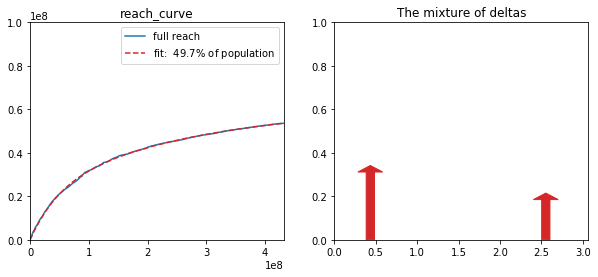

In [4]:
# Calculating the population size
df_census = spark.table("amir.experian_census_5demos_counts")
population_size = df_census.agg(F.sum("population")).collect()[0][0]

# Fitting on the mixture of deltas and plot
alphas, rates = fit_mixture_of_deltas(reach, n_deltas=2, population_size=population_size)
plot_reach_curve(reach, alphas=alphas, rates=rates, 
                 plot_deltas=True, population_size=population_size)

In [5]:
df_dirac_mixtures = pd.DataFrame([[1.0, alphas, rates]], columns=['ratio', 'alphas', 'rates'])

# Generate the VID assignment table : probability and VID ranges
vid_assignment_table = spark.createDataFrame(
    generate_vid_assignment_table(df_dirac_mixtures, population_size=population_size, normalize=False)
)

vid_assignment_table.show()

,prob_>=,prob_<,alpha,rate,start_VID,total_VID
0,0.000000,0.135204,0.311747,0.433698,1,39213949
1,0.135204,0.607632,0.184937,2.554539,39213950,23262788
2,0.607632,1.000000,0.000000,0.000000,0,1


In [6]:
# The parameter for plotting the VID counts
vid_reach_kwargs = {
    'jump' : 100,
    'ylim' : (0, 1.0e8),
    'axes_info' : { 
        'color'      : 'C0',
        'linestyle'  : '',
        'marker'     : 'd',
        'markersize' : 4,
        'label'      : 'VID count' 
    }
}

(<matplotlib.figure.Figure at 0x7f0ac933ba58>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f0ac007f9e8>,
       dtype=object))

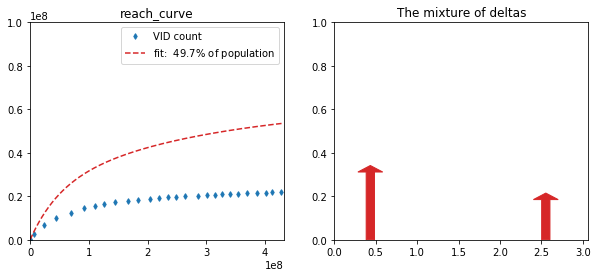

In [7]:
# Using the "uid" mode for the VID assignment that uses `user_id` for the source of randomness
vid_impressions = assign_vids(impressions_exploded, vid_assignment_table, 
                              population_size=population_size, mode="uid")

vid_reach = generate_reach_table(vid_impressions, id_col="vid", mode="count")

# Plot the VID counts vs reported reach
plot_reach_curve(vid_reach, alphas=alphas, rates=rates, 
                 plot_deltas=True, population_size=population_size, 
                 reach_kwargs=vid_reach_kwargs)

(<matplotlib.figure.Figure at 0x7f0ac01668d0>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f0ac00b94e0>,
       dtype=object))

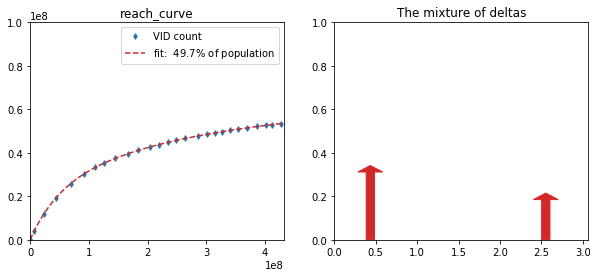

In [8]:
# Using the "uid_time" mode for the VID assignment
vid_impressions = assign_vids(impressions_exploded, vid_assignment_table, 
                              population_size=population_size, mode="uid_time")

vid_reach = generate_reach_table(vid_impressions, id_col="vid", mode="count")

# Plot the VID counts vs reported reach
plot_reach_curve(vid_reach, alphas=alphas, rates=rates, 
                 plot_deltas=True, population_size=population_size, 
                 reach_kwargs=vid_reach_kwargs)

In [9]:
vid_pool_info = mixture_of_delta_pool_info(vid_impressions, vid_assignment_table)
vid_pool_info.show()

,alpha,rate,alpha * rate,VID_pool_size,impressions,VID_reach,distinct_users
0,0.000000,0.000000,0.000000,1,169336390,1,41878725
1,0.311747,0.433698,0.135204,39213949,58347887,30356113,26825364
2,0.184937,2.554539,0.472428,23262788,203870602,23259230,44392617


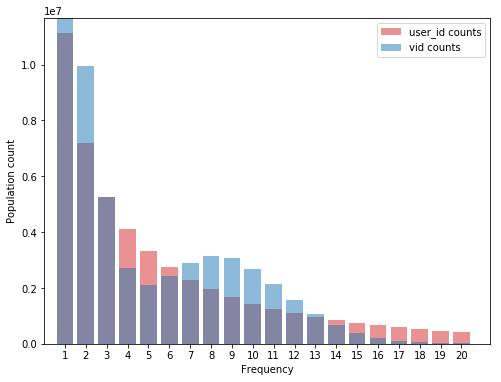

In [10]:
frequency = generate_frequency_table(impressions_exploded, id_col="user_id", mode="count")
vid_frequency = generate_frequency_table(vid_impressions, id_col="vid", mode="count")

fig, ax = plt.subplots(figsize=(8, 6))
plot_frequency(frequency, id_col="user_id", axes=ax, color='C3')
plot_frequency(vid_frequency, id_col="vid", axes=ax, color='C0')